In [10]:
# Thomas Goldman 2023
# DOLPHINN
import sys
import os

#Get the absolute path of the current script
current_path = os.path.dirname(os.path.abspath('__file__'))
dolphinn_path = os.path.join(current_path, '..')
sys.path.append(dolphinn_path)

from DOLPHINN.pinn import DOLPHINN 
from DOLPHINN import plotting


In [20]:
problem = DOLPHINN.from_solution(f"../Data/Optimisation/LVLHm_fuel/case9/", verbose = True)

[DOLPHINN] Initializing the DOLPHINN from old solution at: ../Data/Optimisation/LVLHm_fuel/case9/
[DOLPHINN][Warning] Upload of seed requested: initialisation will be overwritten by the solution
[DOLPHINN] Config file succesfully parsed. Initializing DOLPHINN with:

 ==================== Config Content ====================

----------Functions----------
dynamics                       TwoBodyProblemRadialNonDimensionalControl_mass
input_transform                None
output_transform               InitialFinalStateLayer_Radial_tanh_mass
objective                      OptimalFuel

----------Problem----------
initial_state                  [1.0, 0.0, 1.0]
final_state                    [1.5, 0.0, 0.816496580927726]
mu                             1.32712440042e+20
m                              100
a                              10
umax                           0.1
isp                            2500
length_scale                   150000000000.0
time_scale                     5042908.30539

[DOLPHINN] Setting up the TUDAT simulation
[DOLPHINN] Guidance is internal!
[DOLPHINN] Start Integrating
[DOLPHINN] Finished integrating in 0.05049 s


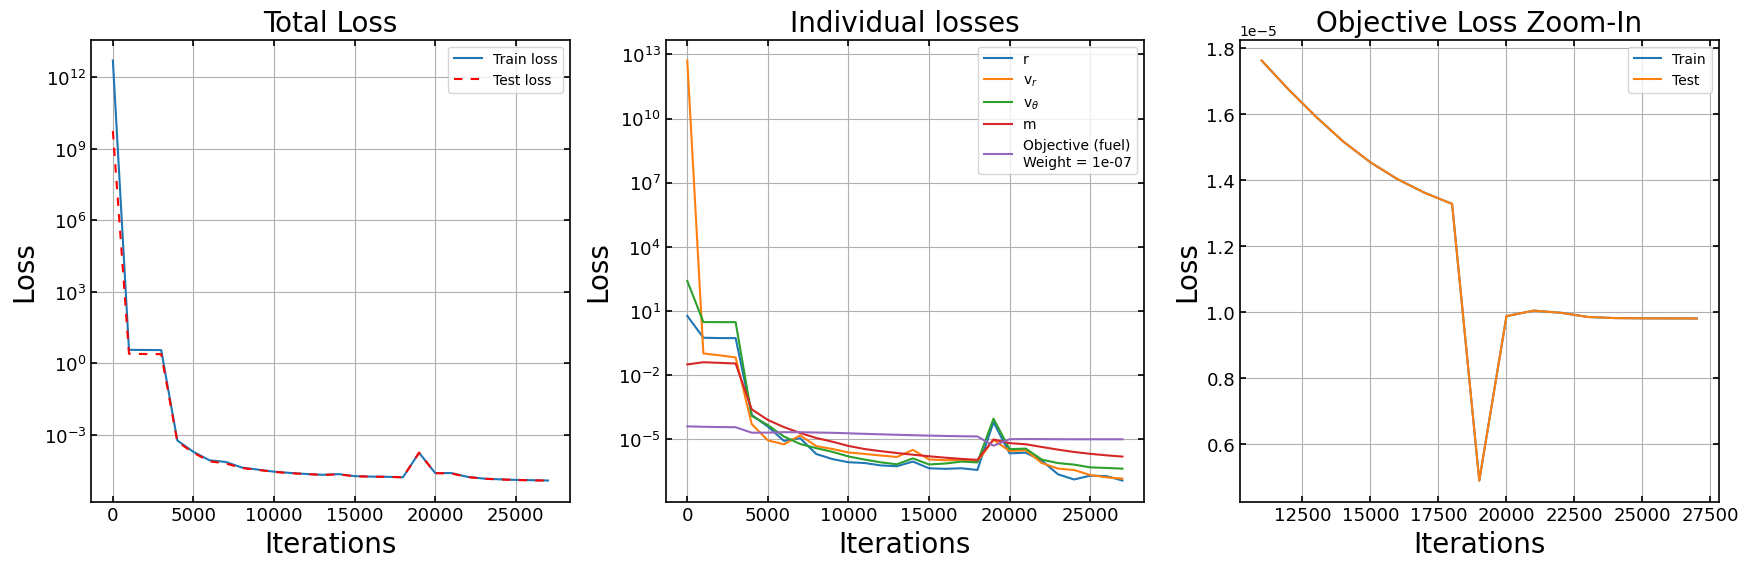

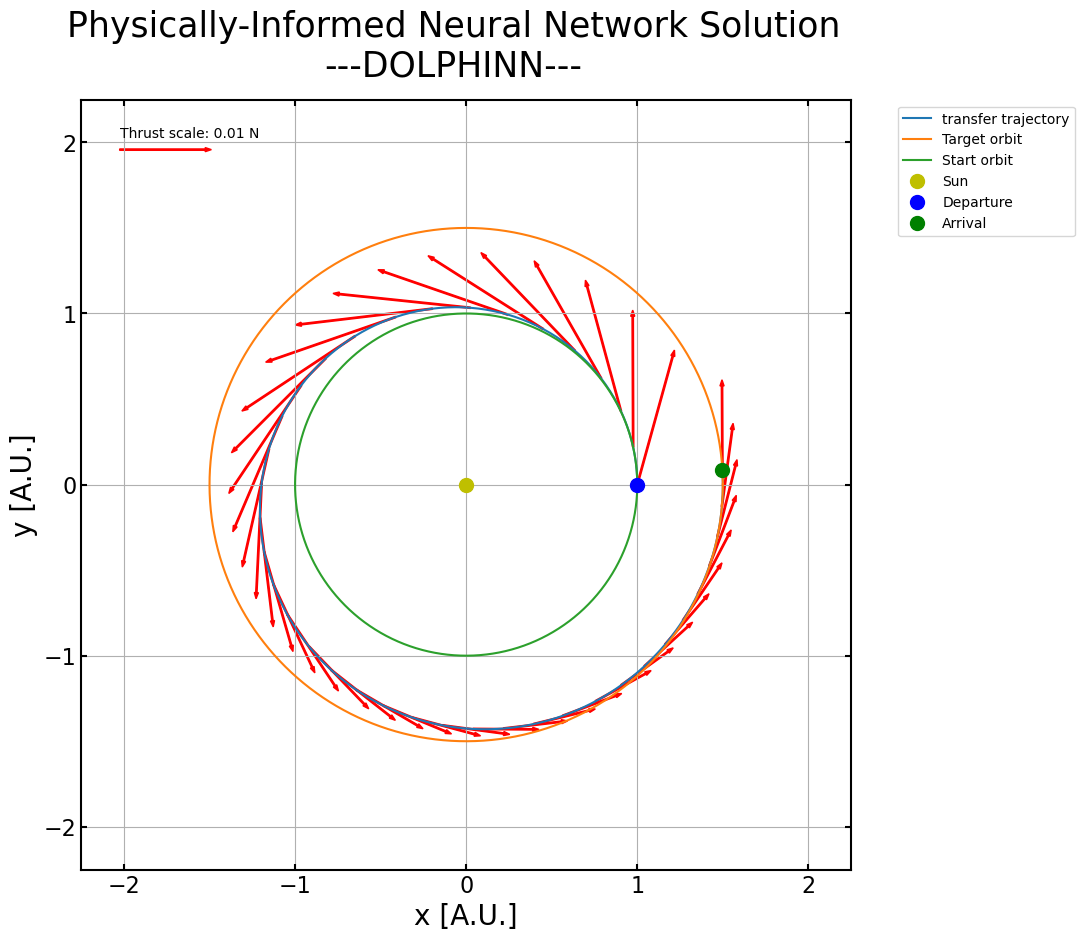

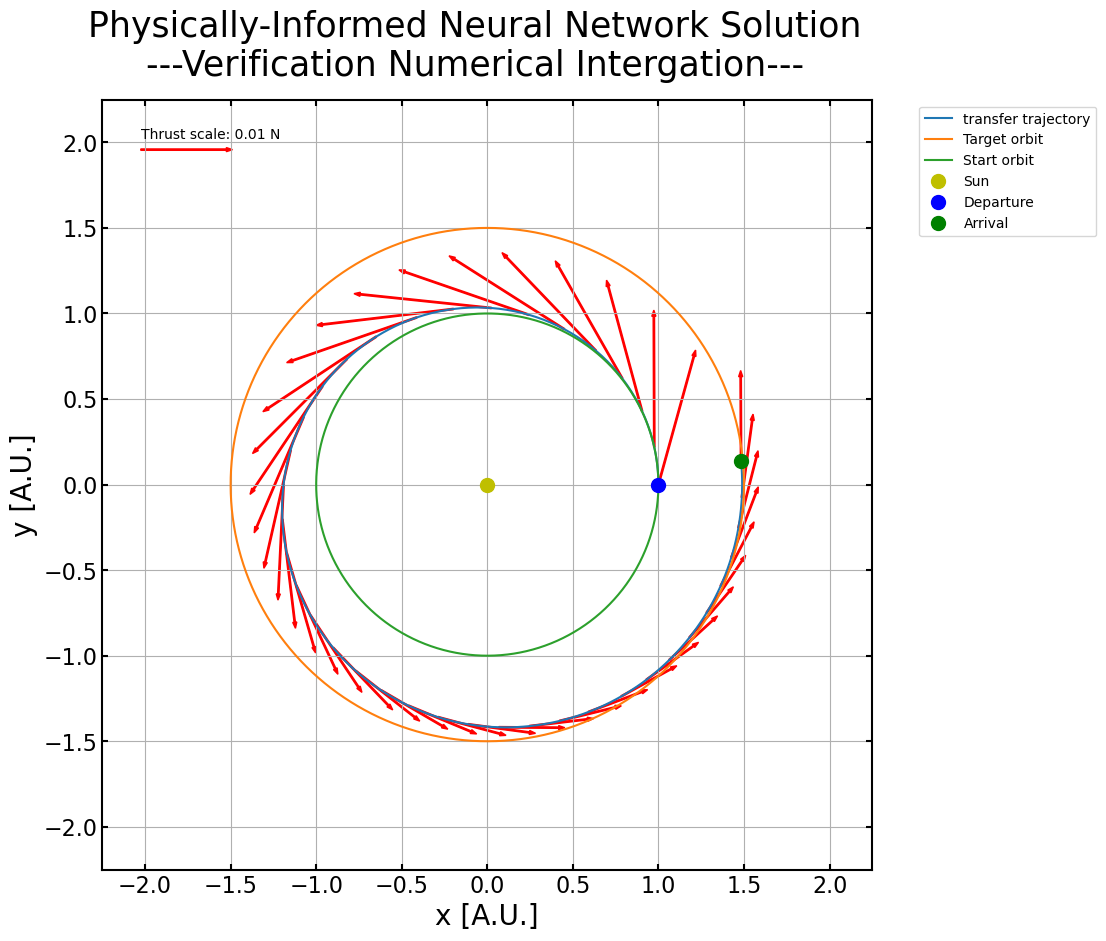

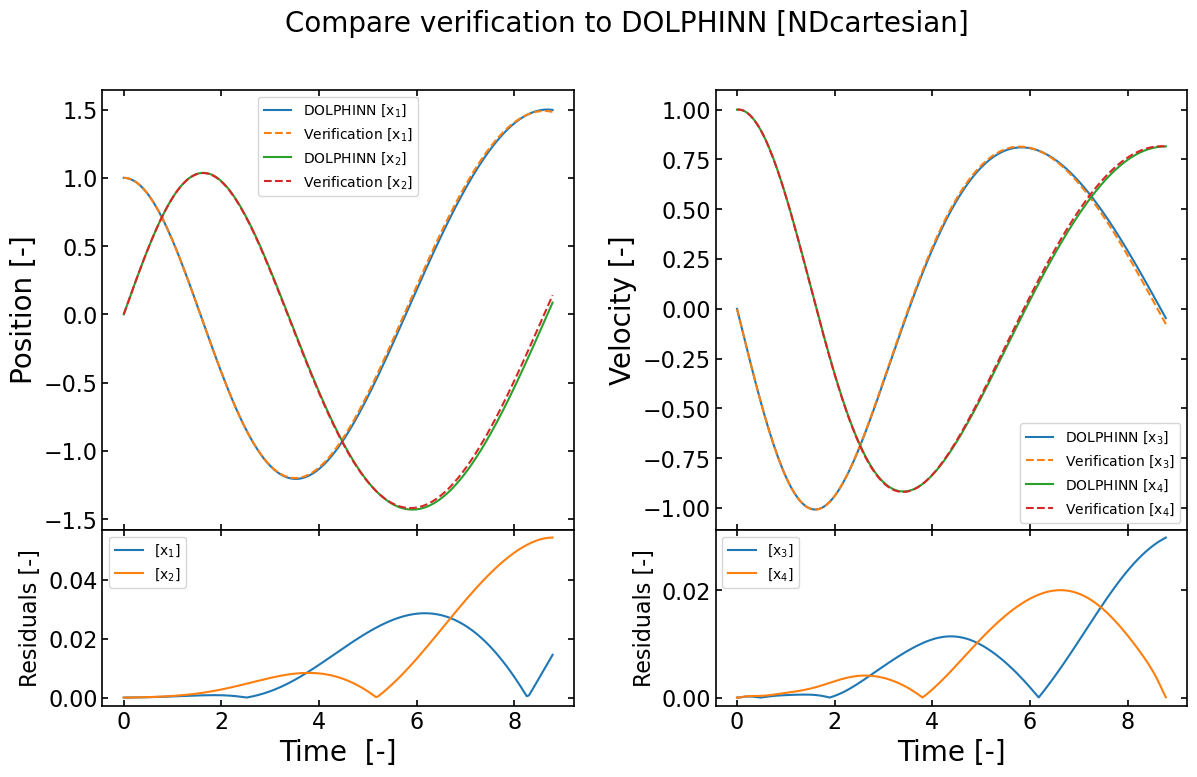

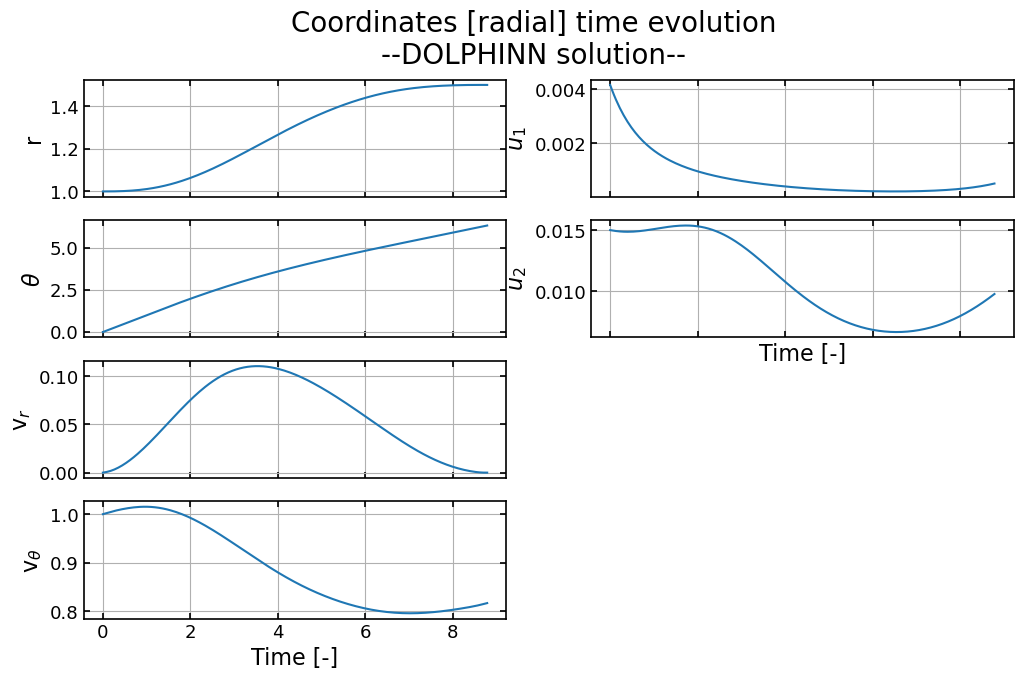

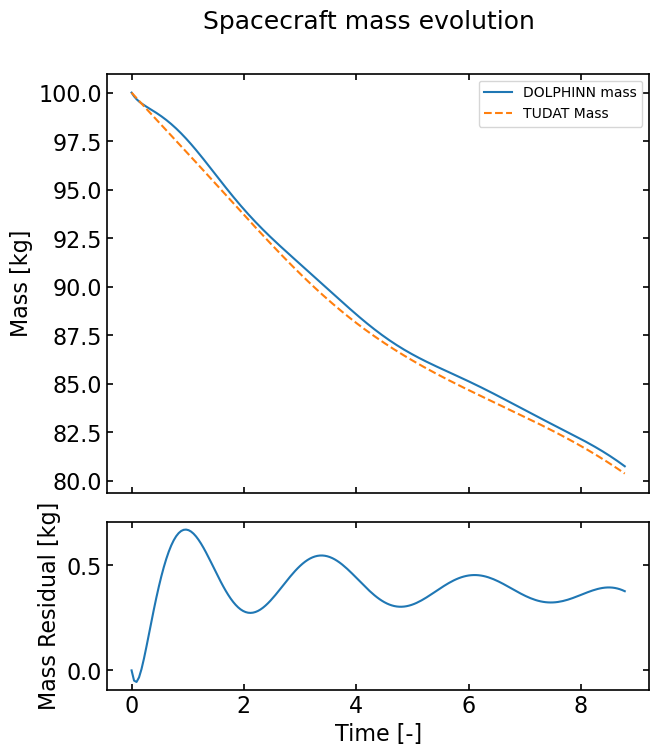

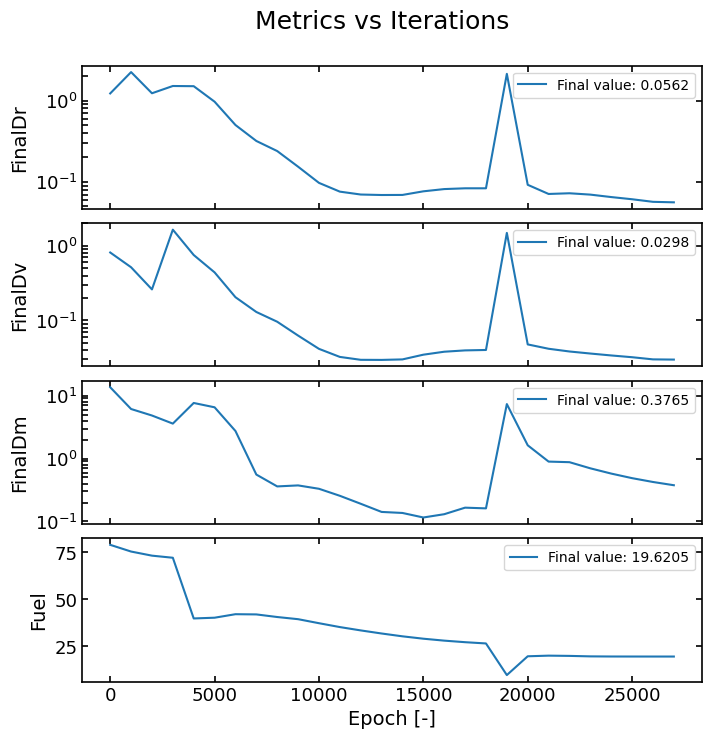

In [21]:
problem.verify()
plotting.plot_loss(problem, objective_zoom = True) 

plotting.plot_transfer(problem, thrust_scale = 0.01, bench = False, thrust=True, r_target = problem.states['radial'][-1,1], N_arrows = 40, grid = True)
plotting.plot_transfer(problem, thrust_scale = 0.01, bench = True, thrust=True, r_target = problem.states['radial'][-1,1], N_arrows = 40, grid = True)

plotting.compare(problem, log = False)
plotting.plot_coordinates(problem, coordinates = "radial", bench = False, plot_control = True)
if problem.dynamics.mass:
    plotting.compare_mass(problem)
if len(problem.metrics) != 0:
    plotting.plot_metrics(problem)